In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reinforcetrader.data_pipeline import RawDataLoader

# Reward Function Definition

We first define certain notations used in the reward functions:

$$
H_b = \{10, 15, 20, 25\}, \quad H_s = \{3, 5, 10\}.
$$

$$
R_h^{\mathrm{ex}}(t)
= \ln\!\left(\frac{P_{t+h}}{P_t}\right)
  - \ln\!\left(\frac{B_{t+h}}{B_t}\right).
$$

$$
w_{h,S,\tau}^{+}(t)
= \frac{e^{R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{R_j^{\mathrm{ex}}(t)/\tau}},
\quad
w_{h,S,\tau}^{-}(t)
= \frac{e^{-R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{-R_j^{\mathrm{ex}}(t)/\tau}},
\space
\mathrm{where}\space h \in S
$$

The reward functions are defined as:

$$
r_{\mathrm{buy}}^{t}
= \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
r_{\mathrm{sell}}^{t}
= \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
r_{\mathrm{hold\mbox{-}in}}^{t}
= \max\!\left(0,\,
  \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  + \sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$

$$
r_{\mathrm{hold\mbox{-}out}}^{t}
= \max\!\left(0,\,
  -\sum_{h \in H_b} w_{h,H_b,\tau_b}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \max\!\left(0,\,
  \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$


In [2]:
# define function to compute the weights for excess return horizons
def softmax_weights(er: pd.DataFrame, t: str, h: int, S: list[int], tau: float, positive: bool = True) -> float:
    if tau <= 0:
        raise ValueError("tau must be > 0")
    t_idx = pd.to_datetime(t)

    cols = [f"{hzn}ER" for hzn in S]
    row = er.loc[t_idx, cols].astype(float).to_numpy()

    sign = 1.0 if positive else -1.0
    logits = (sign * row) / tau
    m = np.max(logits)
    denom = np.exp(logits - m).sum()
    num_val = float(er.loc[t_idx, f"{h}ER"])
    num = np.exp((sign * num_val) / tau - m)
    return float(num / denom)
    
# define function to compute the weighted sum of excess returns
def sum_weighted_returns(er: pd.DataFrame, t: str, S: list[int], tau: float, positive: bool = True) -> float:
    t_idx = pd.to_datetime(t)
    out = 0.0
    for h in S:
        w = softmax_weights(er, t, h, S, tau, positive)   # w^{+} or w^{-}
        rex = float(er.loc[t_idx, f"{h}ER"])
        out += w * rex
    return out

In [3]:
# Define the reward functions as outlined earlier
def buy_reward(er: pd.DataFrame, t: str, Hb: list[int], tb, cost: float):
    return sum_weighted_returns(er, t, Hb, tb, positive=True) - cost

def sell_reward(er: pd.DataFrame, t: str, Hs: list[int], ts, cost: float):
    g = -sum_weighted_returns(er, t, Hs, ts, positive=False)
    return max(0.0, g) - cost

def hold_in_reward(er: pd.DataFrame, t: str, Hb: list[int], Hs: list[int], tb, ts: float):
    g_pos = sum_weighted_returns(er, t, Hb, tb, positive=True)
    g_neg = sum_weighted_returns(er, t, Hs, ts, positive=False)
    return max(0.0, g_pos + g_neg)

def hold_out_reward(er: pd.DataFrame, t: str, Hb: list[int], tb: float):
    avoid_loss = -sum_weighted_returns(er, t, Hb, tb, positive=False)
    miss_gain  = sum_weighted_returns(er, t, Hb, tb, positive=True)
    return max(0.0, avoid_loss) - max(0.0, miss_gain)

# Reward Function Analysis

In [4]:
# Helper functions used for analysis
def compute_excess_returns(start_date, end_date, stock_ticker, index_ticker: str, horizons=list[int]) -> tuple[pd.DataFrame]:
    # Download the data for stocks and the benchmark index
    data_loader = RawDataLoader(start_date=start_date, end_date=end_date, tickers=[stock_ticker, index_ticker], verbose=False)
    
    # Extract the close prices
    hist_prices = data_loader.get_hist_prices().xs(key='Close', level='Price', axis=1)
    
    # Compute excess returns on provided horizons
    excess_returns = pd.DataFrame(index=hist_prices.index)
    for h in horizons:
        hFR = np.log(hist_prices.shift(-h) / hist_prices)
        excess_returns[f'{h}ER'] = hFR[stock_ticker] - hFR[index_ticker]
    excess_returns.dropna(inplace=True)

    return hist_prices, excess_returns

def compute_rewards(er: pd.DataFrame, Hb, Hs: list[int], tb, ts, cost: float) -> pd.DataFrame:
    rewards = pd.DataFrame(index=er.index, columns=['Buy', 'Hold-In','Sell', 'Hold-Out'])
    for idx in rewards.index:
        rewards.loc[idx, 'Buy'] = buy_reward(er, idx, Hb, tb, cost)
        rewards.loc[idx, 'Hold-In'] = hold_in_reward(er, idx, Hb, Hs, tb, tb)
        rewards.loc[idx, 'Sell'] = sell_reward(er, idx, Hs, ts, cost)
        rewards.loc[idx, 'Hold-Out'] = hold_out_reward(er, idx, Hb, tb)

    return rewards

In [5]:
def analyze_reward(start_date: str, end_date: str, stock_ticker: str, index_ticker: str, reward_params: dict[str, object]):
    # Extract reward function params
    Hb, Hs = reward_params['Hb'], reward_params['Hs']
    tb, ts = reward_params['tb'], reward_params['ts']
    cost = reward_params['cost']
    horizons = list(set(Hb + Hs))
    
    # Retrieve historical prices and compute excess returns
    hist_prices, excess_returns = compute_excess_returns(start_date, end_date, stock_ticker, index_ticker, horizons)
    
    # Compute reward for each day based on the defined reward functions
    rewards = compute_rewards(excess_returns, Hb, Hs, tb, ts, cost)

    # Compute the cumulative returns for plotting purposes
    cum_returns = (hist_prices.pct_change() + 1).cumprod().dropna()
    
    plt.figure(figsize=(16, 5))
    plt.plot(cum_returns, label=[f'{t} Returns' for t in cum_returns.columns])
    plt.legend()
    plt.show()
    

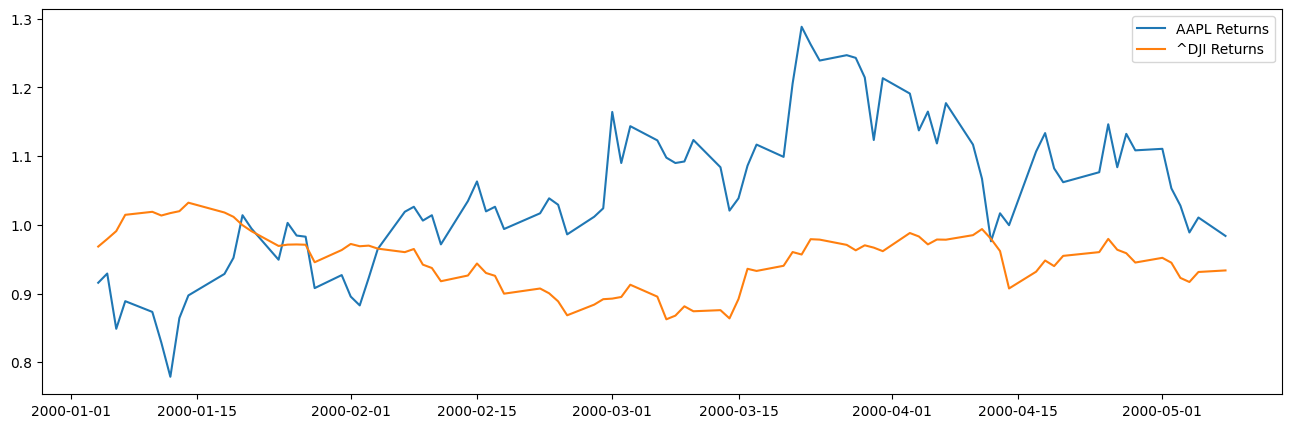

In [6]:
params = {
    'Hb': [10, 15, 20, 25],
    'Hs': [3, 5, 10],
    'tb': 0.5,
    'ts': 0.25,
    'cost': 0.0005
}

analyze_reward(start_date='2000-01-01', end_date='2000-05-09', stock_ticker='AAPL', index_ticker='^DJI', reward_params=params)